# INM702 Coursework - Task 1

In [1]:
from keras import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from numpy.random import default_rng as rng
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

## Load Dataset

In [2]:
# Load the dataset and split into train, test and validation sets
def load_dataset():

    data = datasets.mnist.load_data()

    (X_train, y_train), (X_test, y_test) = data
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)
    
    # Standardise X inputs
    X_train = X_train / 255
    X_test = X_test / 255
    X_valid = X_valid / 255

    # One hot encode y outputs
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_valid = to_categorical(y_valid)

    # Flatten and scale X inputs
    X_train = np.reshape(X_train, [X_train.shape[0], 28 * 28])
    X_test = np.reshape(X_test, [X_test.shape[0], 28 * 28])
    X_valid = np.reshape(X_valid, [X_valid.shape[0], 28 * 28])

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    X_valid = StandardScaler().fit_transform(X_valid)
    
    print(X_train[0])
    print(y_test)

    print(X_valid.shape)
    
    return X_train, X_test, y_train, y_test, X_valid, y_valid

In [3]:
X_train, X_test, y_train, y_test, X_valid, y_valid = load_dataset()

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.56440219e-03 -4.56440219e-03 -4.56440219e-03 -4.56440219e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.56440219e-03 -5.26560617e-03 -9.83806357e-03 -1.28208593e-02
 -1.52823109e-02 -1.95020891e-02 -2.52071858e-02 -2.83985365e-02
 -2.95919872e-02 -3.02927615e-02 -3.20027390e-02 -3.05751788e-02
 -3.34009966e-02 -3.00731114e-02 -2.40009105e-02 -1.93591109e-02
 -1.59407336e-02 -1.06679678e-02 -7.77093042e-03 -4.56440219e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.56440219e-03
 -8.34497013e-03 -1.27302

## Relu Layer

In [4]:
# Contains the forward and backward pass functions for the ReLU layers
class Activation_Layer_ReLU:
    
    # Applies the ReLU function on a given input x
    def forward_pass(self, x):
        
        self.x = x
        
        return np.maximum(0, x)
    
    # Applies the derivative ReLU function on the given input x from the forward pass
    def backward_pass(self, dvalues):
        
        return (np.greater(self.x, 0).astype(int)) * dvalues
        

## Sigmoid Layer

In [5]:
# Contains the forward and backward pass functions for the Sigmoid layers
class Activation_Layer_Sigmoid:
    
    # Applies the Sigmoid function on a given input x
    def forward_pass(self, x):
        
        self.sigmoid = 1 / (1 + np.exp(-x))
        
        return self.sigmoid
    
    # Applies the derivative Sigmoid function using the sigmoid values calculated in the forward pass
    def backward_pass(self, dvalues):
        
        return (self.sigmoid * (1 - self.sigmoid)) * dvalues


## Softmax Layer

In [6]:
# Contains the forward and backward pass functions for the Softmax layers
# Backward pass function is currently unused
class Activation_Layer_Softmax:
    
    # Applies the Softmax function on a given input x
    def forward_pass(self, x):
        
        exponents = np.exp(x - np.max(x, axis = 1, keepdims = True))
        
        self.softmax_out = exponents / np.sum(exponents, axis = 1, keepdims = True)
        
        return self.softmax_out
    
    # Applies the derivative Softmax function using the softmax values calculated in the forward pass
    # This function is currently unused, as the derivative of the softmax function is not needed due to the use of
    # the derivative of the Cross Entropy Loss function
    def backward_pass(self, dvalues):
        
        # Create empty array same size as input gradients
        self.dinputs = np.empty_like(dvalues)
        
        for idx, (single_output, single_dvalue) in enumerate(zip(self.softmax_out, dvalues)):
            
            # Flatten output
            single_output = single_output.reshape(-1, 1)
            
            # Create a jacobian matrix for each output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T) 
            
            # Calculate sample-wise gradients
            self.dinputs[idx] = np.dot(jacobian_matrix, single_dvalue)
        
        return self.dinputs * dvalues


## Dense Layer

In [7]:
# Contains the initialisation of weights and biases, and forward and backward pass functions for the Dense Layers
# This class also performs L1 and L2 Regularisation during the backward pass
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons, L1w_reg = 0, L2w_reg = 0, L1b_reg = 0, L2b_reg = 0):
        
        self.weights = (np.random.randn(n_inputs, n_neurons) * np.sqrt(2/n_neurons)) #He Initialisation
        self.biases = 0.01 * (np.random.randn(1, n_neurons))
        
        self.L1w_reg = L1w_reg
        self.L2w_reg = L2w_reg
        
        self.L1b_reg = L1b_reg
        self.L2b_reg = L2b_reg
    
    # Applies the standard Linear function on a given input x
    def forward_pass(self, x):
        
        self.x = x
        
        return np.dot(x, self.weights) + self.biases
    
    # Computes gradients for the layer's weights and biases and performs L1 and L2 regularisation
    def backward_pass(self, dvalues):
        
        N = len(self.x)
        
        self.dweights = np.dot(self.x.T, dvalues)
        self.dbiases = np.sum(dvalues, axis = 0, keepdims = True)
        
        if self.L1w_reg > 0:
            
            self.dL1w_reg = np.ones_like(self.weights)
            self.dL1w_reg[self.weights < 0] = -1
            self.dweights += self.L1w_reg * self.dL1w_reg
        
        if self.L2w_reg > 0:
            
            self.dweights += 2 * self.L2w_reg * self.weights
            
        if self.L1b_reg > 0:
            
            self.dL1b_reg = np.ones_like(self.biases)
            self.dL1b_reg[self.biases < 0] = -1
            self.biases += self.L1b_reg * self.dL1b_reg
        
        if self.L2b_reg > 0:
            
            self.dbiases += 2 * self.L2b_reg * self.biases
        
        self.dinputs = (1/N) * np.dot(dvalues, self.weights.T)
        
        return self.dinputs

## Dropout Layer

In [8]:
# Contains the forward and backward pass functions for the Dropout Layers
class Layer_Dropout:
    
    def __init__(self, drop_prob):
        
        self.drop_prob = 1 - drop_prob
        
    def forward_pass(self, x):
        
        self.x = x
        
        self.mask = (np.random.rand(*self.x.shape) < self.drop_prob) / self.drop_prob
        
        return self.x * self.mask
        
    def backward_pass(self, dvalues):
        
        self.dinputs = dvalues * self.mask
        
        return self.dinputs
    

## Categorical Cross Entropy Loss with Softmax Layer

In [9]:
# Contains the functions used to calculate the cross entropy loss values and its derivative
# This class also implements the forward pass function of the Softmax layer
class Activation_Softmax_Layer_Loss_Cross_Entropy:
    
    def __init__(self):
        
        self.activation = Activation_Layer_Softmax()
    
    # Calculates the mean loss value of the current pass using the Softmax function
    def forward_pass(self, x, y_true):
        
        self.x = x
        
        self.y_pred = self.activation.forward_pass(x)
        
        N = len(self.y_pred)
        y_pred_clipped = np.clip(self.y_pred, 1e-10, 1 - 1e-10)
        
        neg_log_likelihood = -np.log(np.sum(y_pred_clipped * y_true, axis = 1))

        #self.mean_loss = self.loss.calculate_mean_loss(self.softmax_output, y_true)
        self.mean_loss = np.mean(neg_log_likelihood)
        
        return self.y_pred
    
    # Computes the derivative of the Cross Entropy Loss function
    def backward_pass(self, y_pred, y_true):
        
        N = len(y_pred)
        
        #self.dinputs = (1/N) * ((self.softmax_output) * self.activation.backward_pass(dvalues))

        #self.dinputs = np.mean((1/N) * np.sum(np.dot(self.x.T, y_pred - y_true), axis = 1))
        
        #self.dinputs = (1/N) * np.sum(np.dot((y_pred - y_true), self.x.T), axis = 1)
        
        #self.dinputs = y_pred - y_true
        
        #self.dinputs = np.mean((1/N) * np.sum(np.dot(self.x.T, y_pred - y_true), axis = 1))
        
        #print(((y_pred - y_true) * self.x).shape)
        
        if len(y_true.shape) == 2:
            
            y_true = np.argmax(y_true, axis = 1)
            
        self.dinputs = y_pred.copy()
        
        self.dinputs[range(N), y_true] -= 1
        
        self.dinputs = (1/N) * self.dinputs

        
        return self.dinputs
    

## Stochastic Gradient Descent Optimiser

In [10]:
# Contains the functions used to perform Stocastic Gradient Descent with Momentum and Learning Rate Decay
class Optimiser_SGD:
    
    def __init__(self, learning_rate = 0.5, decay = 0, momentum = 0):
        
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    # Decays learning rate by a specified value
    def update_learning_rate(self):
        
        if self.decay:
            
            self.current_learning_rate = self.learning_rate * (1/(1 + self.decay * self.iterations))
    
    # This function is used to help calculate the decay rate
    def update_iterations(self):
        
        self.iterations += 1
    
    # Updates the weights and biases of the given layer by using their respective gradient values
    def update_values(self, layer):
        
        if self.momentum:
            
            # Generate momentum variables none exist in the current layer
            if not hasattr(layer, "weight_momentum"):
                
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.bias_momentum = np.zeros_like(layer.biases)
                
            new_weights = (self.momentum * layer.weight_momentum) - (self.current_learning_rate * layer.dweights)
            layer.weight_momentum = new_weights
            
            new_biases = (self.momentum * layer.bias_momentum) - (self.current_learning_rate * layer.dbiases)
            layer.bias_momentum = new_biases
        
        # If momentum is not being used in the model, the standard uodate methods should be applied
        else:
            
            new_weights -= self.learning_rate * layer.dweights
            new_biases -= self.learning_rate * layer.dbiases
        
        layer.weights += new_weights
        layer.biases += new_biases
        

## Neural Network Class

In [32]:
# The main class of the Neural Network
# Contains functions to train the network on given inputs, as well as generate predictions when given new data
class NeuralNetwork:
    
    def __init__(self, learning_rate, batch_size, epochs, input_layer_size, output_layer_size, neuron_size):
        
        self.layers = []
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_layer_size = input_layer_size
        self.output_layer_size = output_layer_size
        self.neuron_size = neuron_size
        
        # Records all loss and accuracy values for later analysis
        self.loss_history = []
        self.accuracy_history = []
        
        self.valid_loss_history = []
        self.valid_accuracy_history = []
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        
        train_batches = self.generate_batches(X_train, y_train, self.batch_size)
        valid_batches = self.generate_batches(X_valid, y_valid, self.batch_size)
        
        self.num_train_batches = len(train_batches)
        self.num_valid_batches = len(valid_batches)
        
        self.loss_activation = Activation_Softmax_Layer_Loss_Cross_Entropy()
        self.optimiser = Optimiser_SGD(learning_rate = self.learning_rate, decay = 0.001, momentum = 0.99)
        
        print(len(train_batches))
        
        for epoch in range(self.epochs):
        
            idx = 0
            
            for batch in train_batches:

                idx += 1

                #print("Batch", idx, "of", self.num_train_batches)

                X_train, y_train = batch

                #for epoch in range(self.epochs):

                # Forward pass
                layer_output = self.layers[0].forward_pass(X_train)

                for layer in self.layers[1:]:

                    layer_output = layer.forward_pass(layer_output)

                forward_pass_output = self.loss_activation.forward_pass(layer_output, y_train)

                loss = self.loss_activation.mean_loss

                y_pred = np.argmax(forward_pass_output, axis = 1)
                y_valid = np.argmax(y_train, axis = 1)

                accuracy = accuracy_score(y_valid, y_pred)

                # Backward Pass
                layer_gradient = self.loss_activation.backward_pass(layer_output, y_train)

                for layer in reversed(self.layers[:len(self.layers) - 1]):

                    layer_gradient = layer.backward_pass(layer_gradient)

                # Optimise gradients
                self.optimise("SGD")               

            # Run validation for this epoch
            for valid_batch in valid_batches:
                
                X_valid, y_valid = valid_batch
                
                valid_loss, valid_accuracy = self.predict(X_valid, y_valid)
                
                #self.valid_loss_history.append(valid_loss)
                #self.valid_accuracy_history.append(valid_accuracy)
            
            self.loss_history.append(loss)
            self.accuracy_history.append(accuracy)
            
            self.valid_loss_history.append(valid_loss)
            self.valid_accuracy_history.append(valid_accuracy)
            
            print("epoch:", epoch, "\ttrain loss:", loss, "\tvalid loss:", valid_loss, 
                  "\tvalid acc:", valid_accuracy,"\ttrain acc:", accuracy, "\n")
        
    def predict(self, X_test, y_test):
        
        layer_output = self.layers[0].forward_pass(X_test)
                
        for layer in self.layers[1:]:
            
            # Skip dropout during testing
            if isinstance(layer, Layer_Dropout):
                
                continue
                
            layer_output = layer.forward_pass(layer_output)
                
        forward_pass_output = self.loss_activation.forward_pass(layer_output, y_test)

        loss = self.loss_activation.mean_loss

        y_pred = np.argmax(forward_pass_output, axis = 1)
        y_valid = np.argmax(y_test, axis = 1)

        accuracy = accuracy_score(y_valid, y_pred)
        
        return loss, accuracy
    
    # Allows any number of layers to be added to the network
    def add(self, layer):
        
        self.layers.append(layer)
    
    # Specified optimiser is used to update weights and biases
    # If no optimiser is specified, or the specified optimiser does not exist, SGD will be chosen by default
    def optimise(self, optimiser_type):
        
        if optimiser_type == "SGD":
            
            self.optimiser.update_learning_rate() # For learning rate decay
            
            for layer in self.layers:
                
                if isinstance(layer, Layer_Dense):
                    
                    self.optimiser.update_values(layer)
                    
            self.optimiser.update_iterations()
                    
    # Divide training inputs into mini batches to improve performance and accuracy during testing
    def generate_batches(self, X, y, batch_size):
        
        mini_batches = []
        
        X, y = shuffle(X, y)
        
        for idx in range(0, X.shape[0], batch_size):
            
            X_batch = X[idx:idx + batch_size]
            y_batch = y[idx:idx + batch_size]
        
            mini_batches.append((X_batch, y_batch))
        
        return mini_batches
        

In [33]:
# Initialise hyperparameters
learning_rate = 0.3
batch_size = 100
epochs = 50
input_layer_size = X_train.shape[1]
neuron_size = 250
output_layer_size = 10

model = NeuralNetwork(learning_rate = learning_rate, batch_size = batch_size, epochs = epochs, 
                        input_layer_size = input_layer_size, neuron_size = neuron_size, 
                        output_layer_size = 10)

In [34]:
# Add required layers to the network here
# Any reasonable number and configuration of layers can be added to the model,
# but the final layer must be a Softmax layer
model.add(Layer_Dense(X_train.shape[1], neuron_size, 0, 1e-5, 0, 1e-5))
model.add(Activation_Layer_ReLU())

model.add(Layer_Dropout(0.1))

model.add(Layer_Dense(neuron_size, neuron_size, 0, 1e-5, 0, 1e-5))
model.add(Activation_Layer_ReLU())

model.add(Layer_Dense(neuron_size, neuron_size, 0, 1e-5, 0, 1e-5))
model.add(Activation_Layer_ReLU())

#model.add(Activation_Layer_Sigmoid())
#model.add(Layer_Dropout(0.4))

model.add(Layer_Dense(neuron_size, output_layer_size, 0, 1e-5, 0, 1e-5))
model.add(Activation_Layer_Softmax())

In [35]:
model.fit(X_train, y_train, X_valid, y_valid)

480
epoch: 0 	train loss: 1.8921310801052118 	valid loss: 1.806610254304303 	valid acc: 0.71 	train acc: 0.59 

epoch: 1 	train loss: 1.7733200401618359 	valid loss: 1.7450190411964115 	valid acc: 0.76 	train acc: 0.75 

epoch: 2 	train loss: 1.6441932752048667 	valid loss: 1.6615448824628674 	valid acc: 0.82 	train acc: 0.88 

epoch: 3 	train loss: 1.6558688233136911 	valid loss: 1.6380844565831223 	valid acc: 0.85 	train acc: 0.88 

epoch: 4 	train loss: 1.6237042413454497 	valid loss: 1.6077198539339879 	valid acc: 0.9 	train acc: 0.89 

epoch: 5 	train loss: 1.5955077667232667 	valid loss: 1.6026538900711238 	valid acc: 0.91 	train acc: 0.89 

epoch: 6 	train loss: 1.5941090567880085 	valid loss: 1.5932434692479978 	valid acc: 0.92 	train acc: 0.92 

epoch: 7 	train loss: 1.5803415549396356 	valid loss: 1.5768091221764293 	valid acc: 0.93 	train acc: 0.92 

epoch: 8 	train loss: 1.5696494682534898 	valid loss: 1.578331204198961 	valid acc: 0.92 	train acc: 0.92 

epoch: 9 	train lo

In [36]:
test_loss, test_accuracy = model.predict(X_test, y_test)

print("Test loss:", test_loss, "Test accuracy:", test_accuracy)

loss: 1.577184468845345 acc: 0.9366


50 50


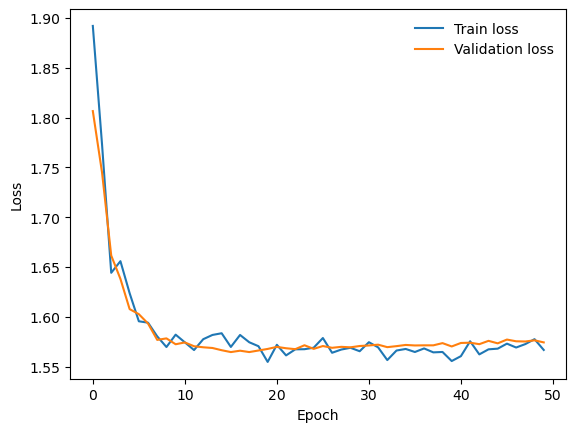

In [37]:
# Plot training and validation loss against epochs

print(len(model.loss_history), len(model.valid_loss_history))

plt.plot(range(0, epochs), model.loss_history, label = "Train loss")
plt.plot(range(0, epochs), model.valid_loss_history, label = "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(frameon = False)
plt.show()

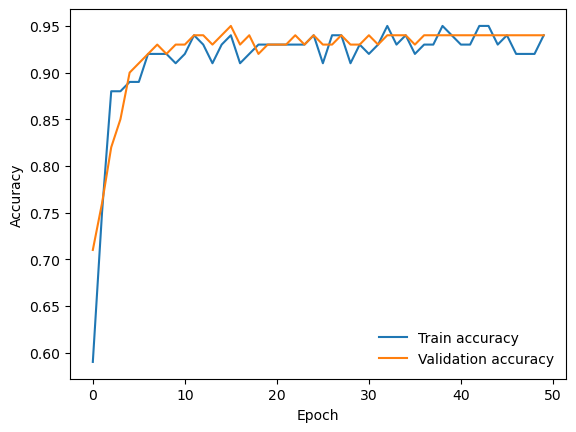

In [38]:
# Plot training and validation accuracy against epochs

plt.plot(range(0, epochs), model.accuracy_history, label = "Train accuracy")
plt.plot(range(0, epochs), model.valid_accuracy_history, label = "Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(frameon = False)
plt.show()